In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import gpflow

import tensorflow as tf
from sklearn.metrics import r2_score

2025-03-20 12:48:09.567586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 12:48:11.043506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742496491.709491   17423 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742496491.828870   17423 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 12:48:12.790754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [3]:
import pickle
with open("biome_pft_dict.pkl", "rb") as f:
    biome_pfts = pickle.load(f)

In [4]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

### setup

In [5]:
obs = xr.open_dataset('wave2_obsStatistics_sudokuBiomes.nc')

In [6]:
# setup
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

In [7]:
pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

In [8]:
file='../../biomes/sudoku_biomes.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

In [9]:
# setup
emulator_dir = './emulators_biomelai/'
out_dir = './samples/'

### Sample

In [16]:
key = str(5)
key = int(key)
n_usamp = 10
n_psamp = 100
usample_all = pd.read_csv("./hmatch/universal_samples.csv")
psample_all = pd.read_csv("./hmatch/pft_samples.csv")
key = 101
usample = usample_all.iloc[key*n_usamp:key*n_usamp+n_usamp]
psample = psample_all.iloc[key*n_psamp:key*n_psamp+n_psamp]

### A Tree 

In [37]:
biome = 'Tropical rainforest'
b = 1
nparameters = 41+15*1

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

u = np.repeat(usample.values,repeats=n_psamp,axis=0)
p = np.tile(psample.values, (n_usamp, 1))
sample = np.concatenate([u,p],axis=1)

loaded_emulator = tf.saved_model.load(emulator_dir + biome)
y_pred, y_pred_var = loaded_emulator.predict(sample)

I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
ix = np.where(I<2)[0]

pft_param_names = [f"{param}_{4}" for param in psample.columns]
columns = np.concatenate((usample.columns,pft_param_names))
biome1_sample = pd.DataFrame(sample[ix],columns=columns)

In [43]:
%%time
biome = 'Tropical savanna'
b = 2
nparameters = 41+15*2

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome1_sample)[0] < 100):
    nx = range(np.shape(biome1_sample)[0])
else:
    nx = np.random.choice(np.shape(biome1_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome1_sample[u_params].iloc[i].values,(n_psamp,1))
    pft4_param_names = [f"{param}_{4}" for param in psample.columns]
    p4 = np.tile(biome1_sample[pft4_param_names].iloc[i].values,(n_psamp,1))
    p14 = psample.values
    sample = np.concatenate([u,p4,p14],axis=1)
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome2_samples = sample[ix,:]
    else:
        biome2_samples = np.concatenate((biome2_samples,sample[ix,:]),axis=0)

# create dataframe
pft14_param_names = [f"{param}_{14}" for param in psample.columns]
columns = np.concatenate((usample.columns,pft4_param_names,pft14_param_names))
biome2_sample = pd.DataFrame(biome2_samples,columns=columns)

CPU times: user 1min 10s, sys: 3.47 s, total: 1min 14s
Wall time: 4min 37s


In [47]:
%%time
biome = 'Subtropical savanna'
b = 3
nparameters = 41+15*3

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome2_sample)[0] < 100):
    nx = range(np.shape(biome2_sample)[0])
else:
    nx = np.random.choice(np.shape(biome2_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome2_sample[u_params].iloc[i].values,(n_psamp,1))
    pft4_param_names = [f"{param}_{4}" for param in psample.columns]
    p4 = np.tile(biome2_sample[pft4_param_names].iloc[i].values,(n_psamp,1))
    pft14_param_names = [f"{param}_{14}" for param in psample.columns]
    p14 = np.tile(biome2_sample[pft14_param_names].iloc[i].values,(n_psamp,1))
    
    p6 = psample.values
    sample = np.concatenate([u,p4,p6,p14],axis=1)

    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome3_samples = sample[ix,:]
    else:
        biome3_samples = np.concatenate((biome3_samples,sample[ix,:]),axis=0)

# create dataframe
pft6_param_names = [f"{param}_{6}" for param in psample.columns]
columns = np.concatenate((u_params,pft4_param_names,pft6_param_names,pft14_param_names))
biome3_sample = pd.DataFrame(biome3_samples,columns=columns)

CPU times: user 1min 12s, sys: 3.21 s, total: 1min 15s
Wall time: 4min 43s


In [48]:
np.shape(biome3_sample)

(4013, 86)

In [50]:
%%time
biome = 'Grasslands'
b = 5
nparameters = 41+15*2

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome3_sample)[0] < 100):
    nx = range(np.shape(biome3_sample)[0])
else:
    nx = np.random.choice(np.shape(biome3_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome3_sample[u_params].iloc[i].values,(n_psamp,1))
    pft14_param_names = [f"{param}_{14}" for param in psample.columns]
    p14 = np.tile(biome3_sample[pft14_param_names].iloc[i].values,(n_psamp,1))
    
    p13 = psample.values
    sample = np.concatenate([u,p13,p14],axis=1)

    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome5_samples = sample[ix,:]
    else:
        biome5_samples = np.concatenate((biome5_samples,sample[ix,:]),axis=0)

# create dataframe
pft13_param_names = [f"{param}_{13}" for param in psample.columns]
columns = np.concatenate((u_params,pft13_param_names,pft14_param_names))
biome5_sample = pd.DataFrame(biome5_samples,columns=columns)


CPU times: user 1min 11s, sys: 2.79 s, total: 1min 14s
Wall time: 5min


In [51]:
np.shape(biome5_sample)

(2402, 71)

In [52]:
%%time
biome = 'Shrubland'
b = 6
nparameters = 41+15*3

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome5_sample)[0] < 100):
    nx = range(np.shape(biome5_sample)[0])
else:
    nx = np.random.choice(np.shape(biome5_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome5_sample[u_params].iloc[i].values,(n_psamp,1))
    pft13_param_names = [f"{param}_{13}" for param in psample.columns]
    p13 = np.tile(biome5_sample[pft13_param_names].iloc[i].values,(n_psamp,1))
    pft14_param_names = [f"{param}_{14}" for param in psample.columns]
    p14 = np.tile(biome5_sample[pft14_param_names].iloc[i].values,(n_psamp,1))
    
    p10 = psample.values
    sample = np.concatenate([u,p10,p13,p14],axis=1)

    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome6_samples = sample[ix,:]
    else:
        biome6_samples = np.concatenate((biome6_samples,sample[ix,:]),axis=0)

# create dataframe
pft10_param_names = [f"{param}_{10}" for param in psample.columns]
pft13_param_names = [f"{param}_{13}" for param in psample.columns]
pft14_param_names = [f"{param}_{14}" for param in psample.columns]
columns = np.concatenate((u_params,pft10_param_names,pft13_param_names,pft14_param_names))
biome6_sample = pd.DataFrame(biome6_samples,columns=columns)

CPU times: user 1min 12s, sys: 4.47 s, total: 1min 17s
Wall time: 4min 45s


In [53]:
np.shape(biome6_sample)

(1419, 86)

In [55]:
%%time
biome = 'Broadleaf evergreen temperate tree'
b = 4
nparameters = 41+15*3

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome6_sample)[0] < 100):
    nx = range(np.shape(biome6_sample)[0])
else:
    nx = np.random.choice(np.shape(biome6_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome6_sample[u_params].iloc[i].values,(n_psamp,1))
    pft13_param_names = [f"{param}_{13}" for param in psample.columns]
    p13 = np.tile(biome6_sample[pft13_param_names].iloc[i].values,(n_psamp,1))
    pft14_param_names = [f"{param}_{14}" for param in psample.columns]
    p14 = np.tile(biome6_sample[pft14_param_names].iloc[i].values,(n_psamp,1))
    
    p5 = psample.values
    sample = np.concatenate([u,p5,p13,p14],axis=1)

    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome4_samples = sample[ix,:]
    else:
        biome4_samples = np.concatenate((biome4_samples,sample[ix,:]),axis=0)

# create dataframe
pft5_param_names = [f"{param}_{5}" for param in psample.columns]
columns = np.concatenate((u_params,pft5_param_names,pft13_param_names,pft14_param_names))
biome4_sample = pd.DataFrame(biome4_samples,columns=columns)

CPU times: user 1min 15s, sys: 8.85 s, total: 1min 24s
Wall time: 4min 27s


In [56]:
np.shape(biome4_sample)

(1087, 86)

In [137]:
# prune up

# biome 4 PFT 5
b4_sample = biome4_sample
b4_sample.to_csv("./samples/tree1_b4.csv", index=False)

cols = np.concatenate((u_params, pft14_param_names))
biome4_unique = biome4_sample[cols].drop_duplicates()

# biome 6 PFT 10
b6_sample = biome6_sample.merge(biome4_unique, on=cols.tolist(), how='inner')
b6_sample.to_csv("./samples/tree1_b6.csv", index=False)

# biome 5 PFT 13
b5_sample = biome5_sample.merge(biome4_unique, on=cols.tolist(), how='inner')
b5_sample.to_csv("./samples/tree1_b5.csv", index=False)

# biome 3 PFT 6
b3_sample = biome3_sample.merge(biome4_unique, on=cols.tolist(), how='inner')
b3_sample.to_csv("./samples/tree1_b3.csv", index=False)

# biome 2 PFT 14
b2_sample = biome2_sample.merge(biome4_unique, on=cols.tolist(), how='inner')
b2_sample.to_csv("./samples/tree1_b2.csv", index=False)

# biome 1 PFT 4
cols = np.concatenate((u_params, pft4_param_names))
biome2_unique = b2_sample[cols].drop_duplicates()
b1_sample = biome1_sample.merge(biome2_unique, on=cols.tolist(), how='inner')
b1_sample.to_csv("./samples/tree1_b1.csv", index=False)

In [149]:
outdir = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
b1_sample.to_csv(outdir+"tree1_b1.csv", index=False)

### B Tree

In [10]:
biome = 'Boreal shrubland'
b = 12
nparameters = 41+15*1

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

u = np.repeat(usample.values,repeats=n_psamp,axis=0)
p = np.tile(psample.values, (n_usamp, 1))
sample = np.concatenate([u,p],axis=1)

loaded_emulator = tf.saved_model.load(emulator_dir + biome)
y_pred, y_pred_var = loaded_emulator.predict(sample)

I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
ix = np.where(I<2)[0]

pft_param_names = [f"{param}_{12}" for param in psample.columns]
columns = np.concatenate((usample.columns,pft_param_names))
biome12_sample = pd.DataFrame(sample[ix],columns=columns)

2025-03-18 09:04:10.363556: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
biome = 'Tundra'
b = 13
nparameters = 41+15*2

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome12_sample)[0] < 100):
    nx = range(np.shape(biome12_sample)[0])
else:
    nx = np.random.choice(np.shape(biome12_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome12_sample[u_params].iloc[i].values,(n_psamp,1))
    pft12_param_names = [f"{param}_{12}" for param in psample.columns]
    p12 = np.tile(biome12_sample[pft12_param_names].iloc[i].values,(n_psamp,1))
    p11 = psample.values
    sample = np.concatenate([u,p11,p12],axis=1)
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome13_samples = sample[ix,:]
    else:
        biome13_samples = np.concatenate((biome13_samples,sample[ix,:]),axis=0)

# create dataframe
pft11_param_names = [f"{param}_{11}" for param in psample.columns]
columns = np.concatenate((usample.columns,pft11_param_names,pft12_param_names))
biome13_sample = pd.DataFrame(biome13_samples,columns=columns)

In [14]:
biome = 'Boreal forest'
b = 10
nparameters = 41+15*3

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome13_sample)[0] < 100):
    nx = range(np.shape(biome13_sample)[0])
else:
    nx = np.random.choice(np.shape(biome13_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome13_sample[u_params].iloc[i].values,(n_psamp,1))
    pft11_param_names = [f"{param}_{11}" for param in psample.columns]
    p11 = np.tile(biome13_sample[pft11_param_names].iloc[i].values,(n_psamp,1))
    pft12_param_names = [f"{param}_{12}" for param in psample.columns]
    p12 = np.tile(biome13_sample[pft12_param_names].iloc[i].values,(n_psamp,1))
    
    p2 = psample.values
    sample = np.concatenate([u,p2,p11,p12],axis=1)

    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome10_samples = sample[ix,:]
    else:
        biome10_samples = np.concatenate((biome10_samples,sample[ix,:]),axis=0)

# create dataframe
pft2_param_names = [f"{param}_{2}" for param in psample.columns]
columns = np.concatenate((u_params,pft2_param_names,pft11_param_names,pft12_param_names))
biome10_sample = pd.DataFrame(biome10_samples,columns=columns)

In [15]:
biome = 'Siberian larch'
b = 9
nparameters = 41+15*3

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

if (np.shape(biome10_sample)[0] < 100):
    nx = range(np.shape(biome10_sample)[0])
else:
    nx = np.random.choice(np.shape(biome10_sample)[0],size=100,replace=False)
    
for n,i in enumerate(nx):
    u = np.tile(biome10_sample[u_params].iloc[i].values,(n_psamp,1))
    pft11_param_names = [f"{param}_{11}" for param in psample.columns]
    p11 = np.tile(biome10_sample[pft11_param_names].iloc[i].values,(n_psamp,1))
    pft12_param_names = [f"{param}_{12}" for param in psample.columns]
    p12 = np.tile(biome10_sample[pft12_param_names].iloc[i].values,(n_psamp,1))
    
    p3 = psample.values
    sample = np.concatenate([u,p3,p11,p12],axis=1)

    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome9_samples = sample[ix,:]
    else:
        biome9_samples = np.concatenate((biome9_samples,sample[ix,:]),axis=0)

# create dataframe
pft3_param_names = [f"{param}_{3}" for param in psample.columns]
columns = np.concatenate((u_params,pft3_param_names,pft11_param_names,pft12_param_names))
biome9_sample = pd.DataFrame(biome9_samples,columns=columns)

In [16]:
np.shape(biome9_sample)

(7708, 86)

In [17]:
# Prune up and save
b9_sample = biome9_sample
#b9_sample.to_csv(outdir+key+"_Btree_biome9.csv", index=False)

cols = np.concatenate((u_params, pft12_param_names))
biome9_unique = biome9_sample[cols].drop_duplicates()

b10_sample = biome10_sample.merge(biome9_unique, on=cols.tolist(), how='inner')
#b10_sample.to_csv(outdir+key+"_Btree_biome10.csv", index=False)

b13_sample = biome13_sample.merge(biome9_unique, on=cols.tolist(), how='inner')
#b13_sample.to_csv(outdir+key+"_Btree_biome13.csv", index=False)

b12_sample = biome12_sample.merge(biome9_unique, on=cols.tolist(), how='inner')
#b12_sample.to_csv(outdir+key+"_Btree_biome9.csv", index=False)


### C tree

In [21]:
%%time
# load Atree sample
d = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
b=4
files = np.sort(glob.glob(d+'*tree1*'+str(b)+'.csv'))
Atree_biome4 = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

CPU times: user 4.45 s, sys: 452 ms, total: 4.9 s
Wall time: 9.7 s


In [22]:
%%time
# load Btree sample
d = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
b=10
files = np.sort(glob.glob(d+'*Btree*'+str(b)+'.csv'))
Btree_biome10 = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

CPU times: user 6.96 s, sys: 309 ms, total: 7.27 s
Wall time: 12.7 s


In [23]:
%%time
uA_unique = Atree_biome4[u_params].drop_duplicates()
uB_unique = Btree_biome10[u_params].drop_duplicates()
uset_intersection = uA_unique.merge(uB_unique, how='inner')

CPU times: user 456 ms, sys: 47.8 ms, total: 504 ms
Wall time: 730 ms


In [24]:
%%time
biome = 'Conifer forest'
b = 8
nparameters = 41+15*4
cols = u_params

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

uset_ix = np.random.choice(len(uset_intersection),size=min(len(uset_intersection),1),replace=False)
for id,ux in enumerate(uset_ix):
    u = np.tile(uset_intersection.iloc[ux].values,(n_psamp,1))
    Atree_subset = Atree_biome4.merge(uset_intersection.loc[[ux]], on=cols.tolist(), how='inner')
    Btree_subset = Btree_biome10.merge(uset_intersection.loc[[ux]], on=cols.tolist(), how='inner')
    pft2_param_names = [f"{param}_{2}" for param in pft_params]
    for i in np.random.choice(np.shape(Btree_subset)[0],size=min(np.shape(Btree_subset)[0],10),replace=False):
        p2 = np.tile(Btree_subset[pft2_param_names].iloc[i].values,(n_psamp,1))
        for j in np.random.choice(np.shape(Atree_subset)[0],size=min(np.shape(Atree_subset)[0],10),replace=False):
            pft13_param_names = [f"{param}_{13}" for param in pft_params]
            p13 = np.tile(Atree_subset[pft13_param_names].iloc[j].values,(n_psamp,1))
            pft14_param_names = [f"{param}_{14}" for param in pft_params]
            p14 = np.tile(Atree_subset[pft14_param_names].iloc[j].values,(n_psamp,1))

        
            p1 = psample.values
            sample = np.concatenate([u,p1,p2,p13,p14],axis=1)
        
            loaded_emulator = tf.saved_model.load(emulator_dir + biome)
            y_pred, y_pred_var = loaded_emulator.predict(sample)
            
            I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
            ix = np.where(I<2)[0]
            if (id ==0):
                biome8_samples = sample[ix,:]
            else:
                biome8_samples = np.concatenate((biome8_samples,sample[ix,:]),axis=0)

# create dataframe
pft1_param_names = [f"{param}_{1}" for param in psample.columns]
columns = np.concatenate((u_params,pft1_param_names,pft2_param_names,pft13_param_names,pft14_param_names))
biome8_sample = pd.DataFrame(biome8_samples,columns=columns)
print('biome 8 done')


biome 8 done
CPU times: user 1min 18s, sys: 2.38 s, total: 1min 20s
Wall time: 1min 54s


In [19]:
np.shape(biome8_sample)

(85, 101)

In [27]:
%%time
biome = 'Mixed deciduous temperate forest'
b = 7
nparameters = 41+15*4

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

nx = np.random.choice(np.shape(biome8_sample)[0],size=min(np.shape(biome8_sample)[0],10),replace=False)

for n,i in enumerate(nx):
    u = np.tile(biome8_sample[u_params].iloc[i].values,(n_psamp,1))
    pft1_param_names = [f"{param}_{1}" for param in psample.columns]
    p1 = np.tile(biome8_sample[pft1_param_names].iloc[i].values,(n_psamp,1))
    pft13_param_names = [f"{param}_{13}" for param in psample.columns]
    p13 = np.tile(biome8_sample[pft13_param_names].iloc[i].values,(n_psamp,1))
    pft14_param_names = [f"{param}_{14}" for param in psample.columns]
    p14 = np.tile(biome8_sample[pft14_param_names].iloc[i].values,(n_psamp,1))

    p7 = psample.values
    sample = np.concatenate([u,p1,p7,p13,p14],axis=1)

    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(sample)
    
    I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
    ix = np.where(I<2)[0]
    if (n ==0):
        biome7_samples = sample[ix,:]
    else:
        biome7_samples = np.concatenate((biome7_samples,sample[ix,:]),axis=0)

# create dataframe
pft7_param_names = [f"{param}_{7}" for param in psample.columns]
columns = np.concatenate((u_params,pft1_param_names,pft7_param_names,pft13_param_names,pft14_param_names))
biome7_sample = pd.DataFrame(biome7_samples,columns=columns)

CPU times: user 7.36 s, sys: 232 ms, total: 7.59 s
Wall time: 9.06 s


In [33]:
# intersection of biome 8 and Btree
b8_unique = biome8_sample[u_params].drop_duplicates()
uB_unique = Btree_biome10[u_params].drop_duplicates()
uset_intersection = b8_unique.merge(uB_unique, how='inner')

In [35]:
%%time
biome = 'Broadleaf deciduous boreal trees' # 2,8,12,13
b = 11
nparameters = 41+15*4
cols = u_params

obs_mean = obs.LAI_mean.sel(biome=b).values
obs_var = obs.LAI_stdev.sel(biome=b).values**2

pft2_param_names = [f"{param}_{2}" for param in psample.columns]
pft12_param_names = [f"{param}_{12}" for param in psample.columns]
pft13_param_names = [f"{param}_{13}" for param in psample.columns]

uset_ix = np.random.choice(len(uset_intersection),size=min(len(uset_intersection),1),replace=False)
for n,ux in enumerate(uset_ix): # loop over unique universal samples
    u = np.tile(uset_intersection.iloc[ux].values,(n_psamp,1))
    # find all biome8 sets and Btree sets for this universal sample
    b8_subset = biome8_sample.merge(uset_intersection.loc[[ux]], on=cols.tolist(), how='inner')
    Btree_subset = Btree_biome10.merge(uset_intersection.loc[[ux]], on=cols.tolist(), how='inner')

    # for each biome8 set, select the respective p2 and p13 parameters
    for i in np.random.choice(np.shape(b8_subset)[0],size=min(np.shape(b8_subset)[0],10),replace=False):
        p2 = np.tile(b8_subset[pft2_param_names].iloc[i].values,(n_psamp,1))
        p13 = np.tile(b8_subset[pft13_param_names].iloc[i].values,(n_psamp,1))

        # for each Btree set, select the respective p12 parameters
        for j in np.random.choice(np.shape(Btree_subset)[0],size=min(np.shape(Btree_subset)[0],10),replace=False):
            p12 = np.tile(Btree_subset[pft12_param_names].iloc[j].values,(n_psamp,1))

            # introduce new PFT
            p8 = psample.values
            sample = np.concatenate([u,p2,p8,p12,p13],axis=1)

            # emulate full sample (n_psamp)
            loaded_emulator = tf.saved_model.load(emulator_dir + biome)
            y_pred, y_pred_var = loaded_emulator.predict(sample)

            # calc implausibility
            I = np.abs(y_pred.numpy().flatten()-obs_mean)/ np.sqrt(obs_var + y_pred_var.numpy().flatten())
            ix = np.where(I<3)[0]
            # save sample
            if (n==0):
                biome11_samples = sample[ix,:]
            else:
                biome11_samples = np.concatenate((biome11_samples,sample[ix,:]),axis=0)

# create NROY dataframe
pft8_param_names = [f"{param}_{8}" for param in psample.columns]
columns = np.concatenate((u_params,pft2_param_names,pft8_param_names,pft12_param_names,pft13_param_names))
biome11_sample = pd.DataFrame(biome11_samples,columns=columns)

CPU times: user 1min 18s, sys: 2.42 s, total: 1min 21s
Wall time: 1min 44s


In [101]:
# create NROY dataframe
pft8_param_names = [f"{param}_{8}" for param in psample.columns]
columns = np.concatenate((u_params,pft2_param_names,pft8_param_names,pft12_param_names,pft13_param_names))
biome11_sample = pd.DataFrame(biome11_samples,columns=columns)

In [104]:
# final prune 

b11_sample = biome11_sample
#b11_sample.to_csv(outdir+key+"_Ctree_biome11.csv", index=False)

cols = np.concatenate((u_params, pft13_param_names))
biome11_unique = biome11_sample[cols].drop_duplicates()

b7_sample = biome7_sample.merge(biome11_unique, on=cols.tolist(), how='inner')
#b7_sample.to_csv(outdir+key+"_Btree_biome7.csv", index=False)

b8_sample = biome8_sample.merge(biome11_unique, on=cols.tolist(), how='inner')
#b8_sample.to_csv(outdir+key+"_Btree_biome8.csv", index=False)


### plot to check

In [105]:
#b_samples = [b1_sample, b2_sample, b3_sample, b4_sample, b5_sample, b6_sample]
b_samples = [b7_sample, b8_sample, b11_sample]

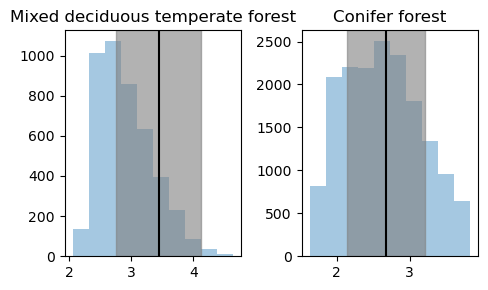

In [109]:
plt.figure(figsize=(12,3))
i = 1
for b, biome in enumerate(biome_names[7:9],start=7):
    plt.subplot(1,5,i)

    obs_mean = obs.LAI_mean.sel(biome=b).values
    obs_var = obs.LAI_stdev.sel(biome=b).values**2
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(b_samples[i-1].values)
    
    plt.hist(y_pred.numpy().flatten(),alpha = 0.4)
    plt.axvline(obs_mean,c='k')
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='grey',alpha=0.6)
    plt.title(biome)
    i = i+1

plt.tight_layout()
plt.savefig('sample_example_postprune_Ctree.png')